# Одна задача с временными рядами
3-часовой хакатон

In [234]:
import time
import csv
import pickle
import random
import time
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from functools import wraps
from matplotlib.font_manager import FontProperties
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.learning_curve import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

%matplotlib inline
pd.options.display.max_columns = None # выводить в датафрейме всё
%pylab inline
figsize(10, 3)

#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 15, 6

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Загрузка данных

In [236]:
tm = time.time()
train = pd.read_csv('d:\\Competitions\\minidatahack\\train.csv')
print ('time = ', time.time() - tm)

time =  0.0


In [237]:
tm = time.time()
test = pd.read_csv('d:\\Competitions\\minidatahack\\test.csv')
print ('time = ', time.time() - tm)

time =  0.0


In [ ]:
# КСТАТИ парсинг дат при считывании
# ateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
# data = pd.read_csv('AirPassengers.csv', parse_dates='Month', index_col='Month',date_parser=dateparse)

In [238]:
test[:10].T

,0,1,2,3,4,5,6,7,8,9
Date,1-Jan-09,2-Jan-09,3-Jan-09,4-Jan-09,5-Jan-09,6-Jan-09,7-Jan-09,8-Jan-09,9-Jan-09,10-Jan-09


In [239]:
train[:10].T

,0,1,2,3,4,5,6,7,8,9
Date,1-Jan-07,2-Jan-07,3-Jan-07,4-Jan-07,5-Jan-07,6-Jan-07,9-Jan-07,11-Jan-07,12-Jan-07,13-Jan-07
Number_SKU_Sold,31762,285955,740781,508796,445951,347351,269415,286603,334356,137819


## Переиндексация
чтобы получились полноценные временные ряды

In [240]:
train['Date'] = pd.to_datetime(train['Date'])
train['ind'] = train.index
train.index = train['Date']
train[:10].T

Date,2007-01-01 00:00:00,2007-01-02 00:00:00,2007-01-03 00:00:00,2007-01-04 00:00:00,2007-01-05 00:00:00,2007-01-06 00:00:00,2007-01-09 00:00:00,2007-01-11 00:00:00,2007-01-12 00:00:00,2007-01-13 00:00:00
Date,2007-01-01 00:00:00,2007-01-02 00:00:00,2007-01-03 00:00:00,2007-01-04 00:00:00,2007-01-05 00:00:00,2007-01-06 00:00:00,2007-01-09 00:00:00,2007-01-11 00:00:00,2007-01-12 00:00:00,2007-01-13 00:00:00
Number_SKU_Sold,31762,285955,740781,508796,445951,347351,269415,286603,334356,137819
ind,0,1,2,3,4,5,6,7,8,9


In [241]:
test['Date'] = pd.to_datetime(test['Date'])
#test['ind'] = test.index
#test.index = test['Date']
test[:10].T

,0,1,2,3,4,5,6,7,8,9
Date,2009-01-01,2009-01-02,2009-01-03,2009-01-04,2009-01-05,2009-01-06,2009-01-07,2009-01-08,2009-01-09,2009-01-10


## Визуализация

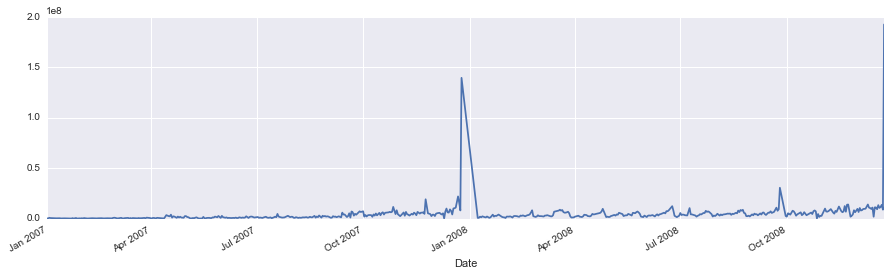

In [242]:
figsize(15, 4)
train.Number_SKU_Sold.plot()

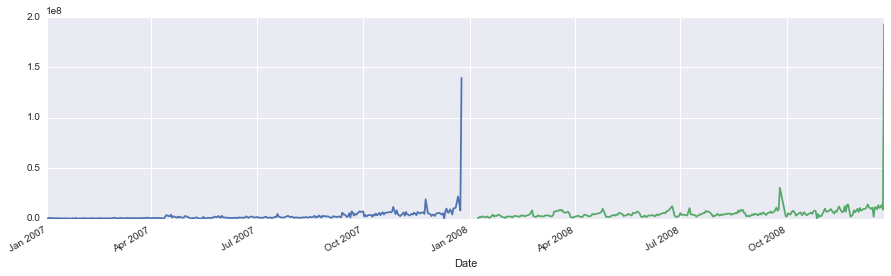

In [243]:
tmp = train.Date.dt # для удобства
train[tmp.year == 2007].Number_SKU_Sold.plot()
train[tmp.year == 2008].Number_SKU_Sold.plot()

Так лучше видно - что происходит в конце года

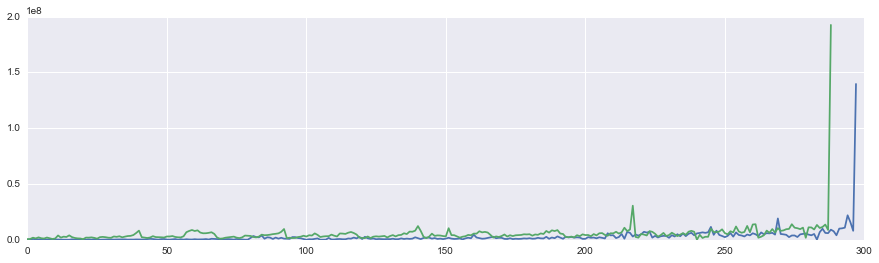

In [244]:
# на одном графике

tmp1 = train[tmp.year == 2007].Number_SKU_Sold
tmp2 = train[tmp.year == 2008].Number_SKU_Sold

tmp1 = tmp1.reset_index()
tmp2 = tmp2.reset_index()

plt.plot(tmp1.Number_SKU_Sold.values)
plt.plot(tmp2.Number_SKU_Sold.values)

Не все дни года есть!

In [246]:
print(tmp1.Number_SKU_Sold.values.shape)
print(tmp2.Number_SKU_Sold.values.shape)

(298,)
(289,)


## Статистика по дням года

In [249]:
print (pd.value_counts(train.Date.dt.dayofweek, sort=False))

# эквивалент
# train['dayofweek'] = train.Date.dt.dayofweek
# train.groupby('dayofweek').size()

0    94
1    99
2    98
3    97
4    93
5    89
6    17
Name: Date, dtype: int64


КАК СДЕЛАТЬ ГИСТОГРАММЫ:

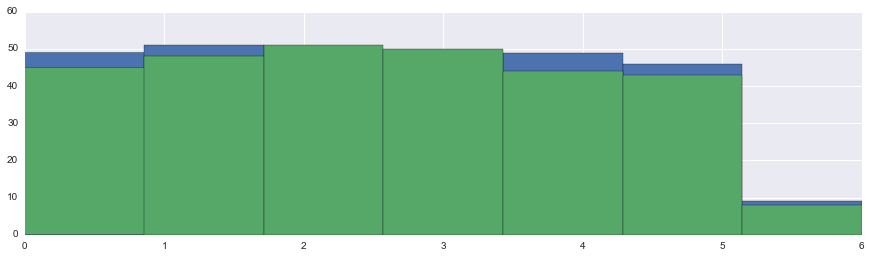

In [254]:
train[tmp.year==2007].Date.dt.dayofweek.hist(bins=7)
train[tmp.year==2008].Date.dt.dayofweek.hist(bins=7)

In [256]:
print (pd.value_counts(test.Date.dt.dayofweek, sort=False))

0    52
1    52
2    52
3    53
4    52
5    52
6    52
Name: Date, dtype: int64


В тесте тупо все даты 2009 года

In [259]:
print (train[tmp.year==2007].shape)
print (train[tmp.year==2008].shape)
print (test.shape)

(298, 3)
(289, 3)
(365, 1)


## Чтобы посмотреть на одном годе
Запихнём всё в 2008-й - он високосный

In [264]:
tmp1['Date2'] = tmp1.Date.apply(lambda x: str(x).replace('2007', '2008'))
#tmp2['Date2'] = tmp2.Date.apply(lambda x: str(x).replace('2008', '2009'))
tmp2['Date2'] = tmp2.Date

tmp1['Date2'] = pd.to_datetime(tmp1['Date2'])
tmp2['Date2'] = pd.to_datetime(tmp2['Date2'])

tmp1.index = tmp1['Date2']
tmp2.index = tmp2['Date2']

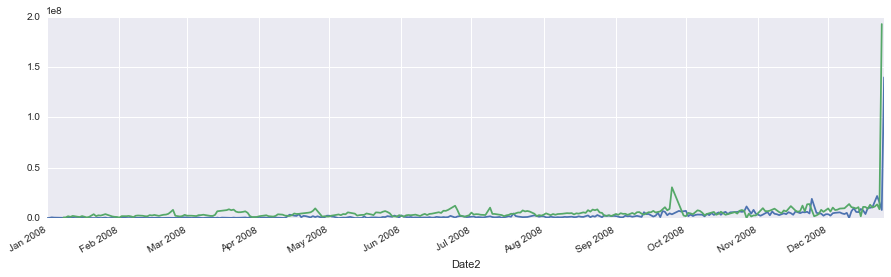

In [265]:
tmp1.Number_SKU_Sold.plot()
tmp2.Number_SKU_Sold.plot()

In [266]:
tmp1[:10].T

Date2,2008-01-01 00:00:00,2008-01-02 00:00:00,2008-01-03 00:00:00,2008-01-04 00:00:00,2008-01-05 00:00:00,2008-01-06 00:00:00,2008-01-09 00:00:00,2008-01-11 00:00:00,2008-01-12 00:00:00,2008-01-13 00:00:00
Date,2007-01-01 00:00:00,2007-01-02 00:00:00,2007-01-03 00:00:00,2007-01-04 00:00:00,2007-01-05 00:00:00,2007-01-06 00:00:00,2007-01-09 00:00:00,2007-01-11 00:00:00,2007-01-12 00:00:00,2007-01-13 00:00:00
Number_SKU_Sold,31762,285955,740781,508796,445951,347351,269415,286603,334356,137819
Date2,2008-01-01 00:00:00,2008-01-02 00:00:00,2008-01-03 00:00:00,2008-01-04 00:00:00,2008-01-05 00:00:00,2008-01-06 00:00:00,2008-01-09 00:00:00,2008-01-11 00:00:00,2008-01-12 00:00:00,2008-01-13 00:00:00


In [267]:
tmp2[:10].T

Date2,2008-01-08 00:00:00,2008-01-09 00:00:00,2008-01-10 00:00:00,2008-01-11 00:00:00,2008-01-12 00:00:00,2008-01-14 00:00:00,2008-01-15 00:00:00,2008-01-16 00:00:00,2008-01-17 00:00:00,2008-01-18 00:00:00
Date,2008-01-08 00:00:00,2008-01-09 00:00:00,2008-01-10 00:00:00,2008-01-11 00:00:00,2008-01-12 00:00:00,2008-01-14 00:00:00,2008-01-15 00:00:00,2008-01-16 00:00:00,2008-01-17 00:00:00,2008-01-18 00:00:00
Number_SKU_Sold,654647,734285,1889530,1243790,2189177,1399967,1125297,2045065,1407984,726871
Date2,2008-01-08 00:00:00,2008-01-09 00:00:00,2008-01-10 00:00:00,2008-01-11 00:00:00,2008-01-12 00:00:00,2008-01-14 00:00:00,2008-01-15 00:00:00,2008-01-16 00:00:00,2008-01-17 00:00:00,2008-01-18 00:00:00


In [268]:
test['Date2'] = test.Date.apply(lambda x: str(x).replace('2009', '2008'))
test['Date2'] = pd.to_datetime(test['Date2'])
test.index = test['Date2']
test[:10].T

Date2,2008-01-01 00:00:00,2008-01-02 00:00:00,2008-01-03 00:00:00,2008-01-04 00:00:00,2008-01-05 00:00:00,2008-01-06 00:00:00,2008-01-07 00:00:00,2008-01-08 00:00:00,2008-01-09 00:00:00,2008-01-10 00:00:00
Date,2009-01-01,2009-01-02,2009-01-03,2009-01-04,2009-01-05,2009-01-06,2009-01-07,2009-01-08,2009-01-09,2009-01-10
Date2,2008-01-01,2008-01-02,2008-01-03,2008-01-04,2008-01-05,2008-01-06,2008-01-07,2008-01-08,2008-01-09,2008-01-10


In [269]:
# вот так переименование колонок!!!!


tmp1.rename(columns = {'Number_SKU_Sold':'N2007'}, inplace = True)
tmp2.rename(columns = {'Number_SKU_Sold':'N2008'}, inplace = True)
test.rename(columns = {'Number_SKU_Sold':'N2009'}, inplace = True)

# а так нельзя
#tmp1.columns[tmp1.columns=='Number_SKU_Sold'] = 'N2007'
#tmp2.columns[tmp2.columns=='Number_SKU_Sold'] = 'N2008'
#test.columns[test.columns=='Number_SKU_Sold'] = 'N2009'

In [270]:
result = pd.concat([tmp1, tmp2, test], axis=1)

In [271]:
result[:10]


,Date,N2007,Date2,Date,N2008,Date2,Date,Date2
Date2,,,,,,,,
2008-01-01,2007-01-01,31762,2008-01-01,NaT,NaN,NaT,2009-01-01,2008-01-01
2008-01-02,2007-01-02,285955,2008-01-02,NaT,NaN,NaT,2009-01-02,2008-01-02
2008-01-03,2007-01-03,740781,2008-01-03,NaT,NaN,NaT,2009-01-03,2008-01-03
2008-01-04,2007-01-04,508796,2008-01-04,NaT,NaN,NaT,2009-01-04,2008-01-04
2008-01-05,2007-01-05,445951,2008-01-05,NaT,NaN,NaT,2009-01-05,2008-01-05
2008-01-06,2007-01-06,347351,2008-01-06,NaT,NaN,NaT,2009-01-06,2008-01-06
2008-01-07,NaT,NaN,NaT,NaT,NaN,NaT,2009-01-07,2008-01-07
2008-01-08,NaT,NaN,NaT,2008-01-08,654647,2008-01-08,2009-01-08,2008-01-08
2008-01-09,2007-01-09,269415,2008-01-09,2008-01-09,734285,2008-01-09,2009-01-09,2008-01-09


In [272]:
# устраняем неизвестности
result.ffill(inplace=True)

In [273]:
result['N2008'] = result['N2008'].fillna(654647)
result[:10]

,Date,N2007,Date2,Date,N2008,Date2,Date,Date2
Date2,,,,,,,,
2008-01-01,2007-01-01,31762,2008-01-01,NaT,654647,NaT,2009-01-01,2008-01-01
2008-01-02,2007-01-02,285955,2008-01-02,NaT,654647,NaT,2009-01-02,2008-01-02
2008-01-03,2007-01-03,740781,2008-01-03,NaT,654647,NaT,2009-01-03,2008-01-03
2008-01-04,2007-01-04,508796,2008-01-04,NaT,654647,NaT,2009-01-04,2008-01-04
2008-01-05,2007-01-05,445951,2008-01-05,NaT,654647,NaT,2009-01-05,2008-01-05
2008-01-06,2007-01-06,347351,2008-01-06,NaT,654647,NaT,2009-01-06,2008-01-06
2008-01-07,2007-01-06,347351,2008-01-06,NaT,654647,NaT,2009-01-07,2008-01-07
2008-01-08,2007-01-06,347351,2008-01-06,2008-01-08,654647,2008-01-08,2009-01-08,2008-01-08
2008-01-09,2007-01-09,269415,2008-01-09,2008-01-09,734285,2008-01-09,2009-01-09,2008-01-09


In [274]:
result.columns = ['Date2007', 'N2007', 'Date2007-08', 'Date2008', 'N2008', 'Date2008-08' , 'Date2009', 'Date2009-08' ]

In [276]:
result[:10]

,Date2007,N2007,Date2007-08,Date2008,N2008,Date2008-08,Date2009,Date2009-08
Date2,,,,,,,,
2008-01-01,2007-01-01,31762,2008-01-01,NaT,654647,NaT,2009-01-01,2008-01-01
2008-01-02,2007-01-02,285955,2008-01-02,NaT,654647,NaT,2009-01-02,2008-01-02
2008-01-03,2007-01-03,740781,2008-01-03,NaT,654647,NaT,2009-01-03,2008-01-03
2008-01-04,2007-01-04,508796,2008-01-04,NaT,654647,NaT,2009-01-04,2008-01-04
2008-01-05,2007-01-05,445951,2008-01-05,NaT,654647,NaT,2009-01-05,2008-01-05
2008-01-06,2007-01-06,347351,2008-01-06,NaT,654647,NaT,2009-01-06,2008-01-06
2008-01-07,2007-01-06,347351,2008-01-06,NaT,654647,NaT,2009-01-07,2008-01-07
2008-01-08,2007-01-06,347351,2008-01-06,2008-01-08,654647,2008-01-08,2009-01-08,2008-01-08
2008-01-09,2007-01-09,269415,2008-01-09,2008-01-09,734285,2008-01-09,2009-01-09,2008-01-09


## Тупые ответы по прошлым годам

In [178]:
answ1 = result[['Date2009', 'N2008']]
answ1.columns = ['Date','Number_SKU_Sold']
answ1.to_csv('d:\\Competitions\\minidatahack\\answ1.csv', index=False, date_format='%d-%b-%y')

в файлах придётся убрать лишний день високосного года

а ещё 01-Jan-2016 -> 1-Jan-2016

In [184]:
answ2 = result[['Date2009', 'N2007']]
answ2.columns = ['Date','Number_SKU_Sold']
answ2.to_csv('d:\\Competitions\\minidatahack\\answ2.csv', index=False, date_format='%d-%b-%y')

# скользящее среднее

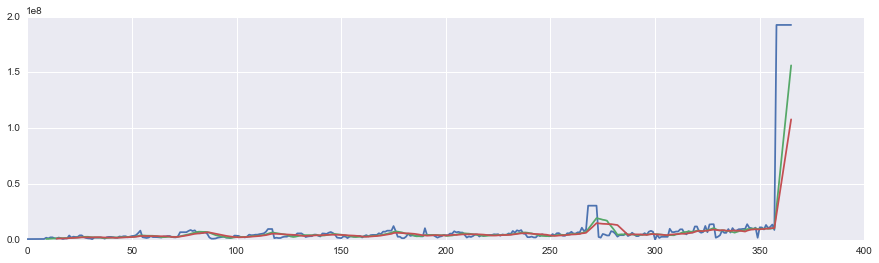

In [278]:
plt.plot(result.N2008.values)
plt.plot(pd.rolling_mean(result.N2008, 10).values)
plt.plot(pd.rolling_mean(result.N2008, 15).values)

In [281]:
result['new'] = pd.rolling_mean(result.N2008, 10)

In [282]:
result[:10]

,Date2007,N2007,Date2007-08,Date2008,N2008,Date2008-08,Date2009,Date2009-08,new
Date2,,,,,,,,,
2008-01-01,2007-01-01,31762,2008-01-01,NaT,654647,NaT,2009-01-01,2008-01-01,NaN
2008-01-02,2007-01-02,285955,2008-01-02,NaT,654647,NaT,2009-01-02,2008-01-02,NaN
2008-01-03,2007-01-03,740781,2008-01-03,NaT,654647,NaT,2009-01-03,2008-01-03,NaN
2008-01-04,2007-01-04,508796,2008-01-04,NaT,654647,NaT,2009-01-04,2008-01-04,NaN
2008-01-05,2007-01-05,445951,2008-01-05,NaT,654647,NaT,2009-01-05,2008-01-05,NaN
2008-01-06,2007-01-06,347351,2008-01-06,NaT,654647,NaT,2009-01-06,2008-01-06,NaN
2008-01-07,2007-01-06,347351,2008-01-06,NaT,654647,NaT,2009-01-07,2008-01-07,NaN
2008-01-08,2007-01-06,347351,2008-01-06,2008-01-08,654647,2008-01-08,2009-01-08,2008-01-08,NaN
2008-01-09,2007-01-09,269415,2008-01-09,2008-01-09,734285,2008-01-09,2009-01-09,2008-01-09,NaN


In [283]:
result['new'] = result.new.fillna('786099.1')

C:\Anaconda3\lib\site-packages\pandas\core\internals.py:4288: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  comp = (nn == nn_at)


In [284]:
result[:10]

,Date2007,N2007,Date2007-08,Date2008,N2008,Date2008-08,Date2009,Date2009-08,new
Date2,,,,,,,,,
2008-01-01,2007-01-01,31762,2008-01-01,NaT,654647,NaT,2009-01-01,2008-01-01,786099.1
2008-01-02,2007-01-02,285955,2008-01-02,NaT,654647,NaT,2009-01-02,2008-01-02,786099.1
2008-01-03,2007-01-03,740781,2008-01-03,NaT,654647,NaT,2009-01-03,2008-01-03,786099.1
2008-01-04,2007-01-04,508796,2008-01-04,NaT,654647,NaT,2009-01-04,2008-01-04,786099.1
2008-01-05,2007-01-05,445951,2008-01-05,NaT,654647,NaT,2009-01-05,2008-01-05,786099.1
2008-01-06,2007-01-06,347351,2008-01-06,NaT,654647,NaT,2009-01-06,2008-01-06,786099.1
2008-01-07,2007-01-06,347351,2008-01-06,NaT,654647,NaT,2009-01-07,2008-01-07,786099.1
2008-01-08,2007-01-06,347351,2008-01-06,2008-01-08,654647,2008-01-08,2009-01-08,2008-01-08,786099.1
2008-01-09,2007-01-09,269415,2008-01-09,2008-01-09,734285,2008-01-09,2009-01-09,2008-01-09,786099.1


In [220]:
answ2 = result[['Date2009', 'new']]
answ2.columns = ['Date','Number_SKU_Sold']
answ2.to_csv('d:\\Competitions\\minidatahack\\answ3.csv', index=False, date_format='%d-%b-%y')

## что там за дни

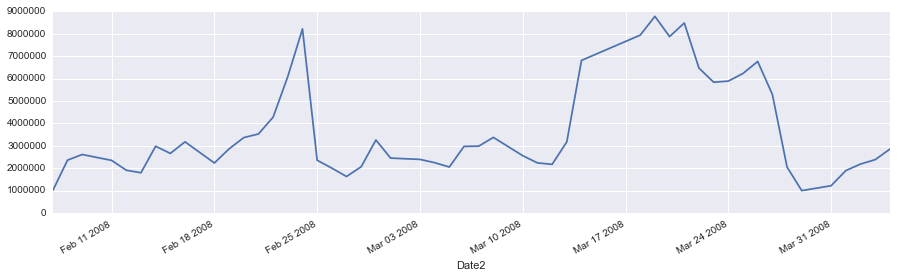

In [285]:
tmp2.N2008[25:75].plot()

# Прогнозирование временных рядов

## AR

In [228]:
r = tmp2['N2008']+0.0

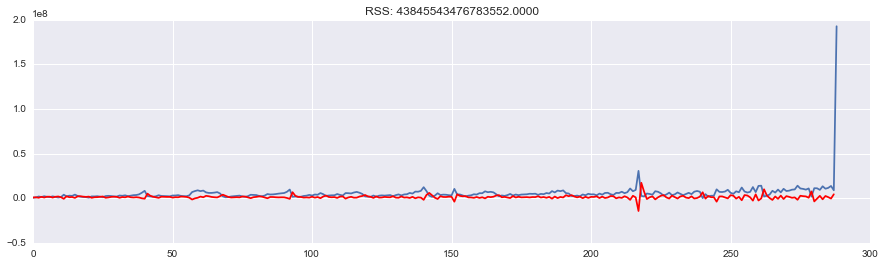

In [229]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(r, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(r)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-r)**2)) 

## MA

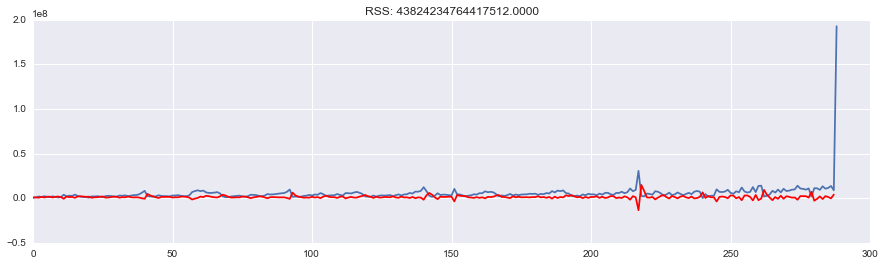

In [230]:
model = ARIMA(r, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(r)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-r)**2))

# combined

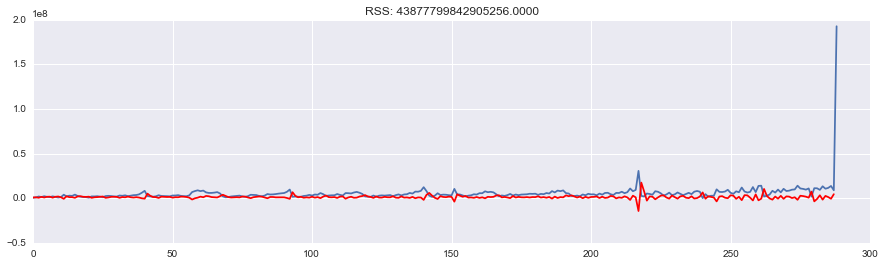

In [232]:
model = ARIMA(r, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(r)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-r)**2))